<a href="https://colab.research.google.com/github/SantiagoJusteValverde/Grupo35_Practica2/blob/main/Grupo35_Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OBJETIVO DE PREDICCIÓN**

*Crear un modelo que prediga si es probable que los empleados
abandonen la empresa, usando un conjunto de datos recopilados por el departamento de
recursos humanos.*

In [213]:
%matplotlib inline
#######
# Importamos todas las dependencias
import numpy as np
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import metrics

np.random.seed(35)

In [214]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
path = "/content/drive/MyDrive/Copia Seguridad/D:/santi/Escritorio/Universidad/Quinto/Segundo cuatrimestre/Aprendizaje Automático/Grupo/Aprendizaje Automático/Práctica 2/"
#path="C:/Users/mferh/DataspellProjects/Grupo35_Practica2/"

inputFilename = "attrition_available_35.pkl"

In [217]:
import pickle
import pandas as pd

with open(path + inputFilename, 'rb') as f:
    df = pickle.load(f)


y_data_set = df['Attrition']
X_data_set = df.drop('Attrition', axis=1)

#print(X.iloc[0]) #imprimimos la primera columna del conjunto de entrada


In [218]:
"""Mostramos  información acerca de nuestro conjunto de datos"""

# Descripción general del conjunto de datos
print('Información general del conjunto de datos:')
print(X_data_set.info())

# Estadísticas descriptivas de las variables numéricas
print('Estadísticas descriptivas de las variables numéricas:')
print(X_data_set.describe())





Información general del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      3671 non-null   float64
 1   absences                 3657 non-null   float64
 2   JobInvolvement           3618 non-null   float64
 3   PerformanceRating        3457 non-null   float64
 4   EnvironmentSatisfaction  3630 non-null   float64
 5   JobSatisfaction          3589 non-null   float64
 6   WorkLifeBalance          3514 non-null   float64
 7   Age                      3660 non-null   float64
 8   BusinessTravel           4410 non-null   object 
 9   Department               3702 non-null   object 
 10  DistanceFromHome         3502 non-null   float64
 11  Education                4410 non-null   int64  
 12  EducationField           3444 non-null   object 
 13  EmployeeCount            3603 non-n

In [219]:
# Calculamos el número de valores nulos por variable

null_counts = X_data_set.isnull().sum()
null_pct = null_counts / len(X_data_set) * 100
null_df = pd.DataFrame({'Variable': null_counts.index, 'Total Nulos': null_counts.values, '% Nulos': null_pct.values})

# Imprimir el DataFrame con los resultados
print("\n-Valores nulos para cada variable de nuestro conjunto de datos de entrada \n")
display(null_df)



-Valores nulos para cada variable de nuestro conjunto de datos de entrada 



,Variable,Total Nulos,% Nulos
0,hrs,739,16.757370
1,absences,753,17.074830
2,JobInvolvement,792,17.959184
3,PerformanceRating,953,21.609977
4,EnvironmentSatisfaction,780,17.687075
5,JobSatisfaction,821,18.616780
6,WorkLifeBalance,896,20.317460
7,Age,750,17.006803
8,BusinessTravel,0,0.000000
9,Department,708,16.054422


Hallamos el tipo de las distintas variables.

Variables categóricas = [BusinessTravel, Departament, Gender, EducationField, Over18, MaritalStatus, JobRole]



In [220]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# Obtener una lista de todas las variables en el conjunto de datos
variables_entrada = list(X_data_set.columns)


# Crear una lista de variables categóricas
variables_categoricas = ['BusinessTravel', 'Department', 'Gender', 'EducationField', 'Over18', 'MaritalStatus', 'JobRole']
variables_numericas = []

# Iterar sobre cada variable y comprobar si es de tipo object
for var in variables_entrada:
    if var not in variables_categoricas:
        variables_numericas.append(var)



# Imprimir el número de variables categóricas
print("-El número total de variables categóricas en el conjunto de datos es: ", len(variables_categoricas))
print("-El número total de variables numéricas en el conjunto de datos es: ", len(variables_numericas))




-El número total de variables categóricas en el conjunto de datos es:  7
-El número total de variables numéricas en el conjunto de datos es:  23


Análisis de las variables numéricas

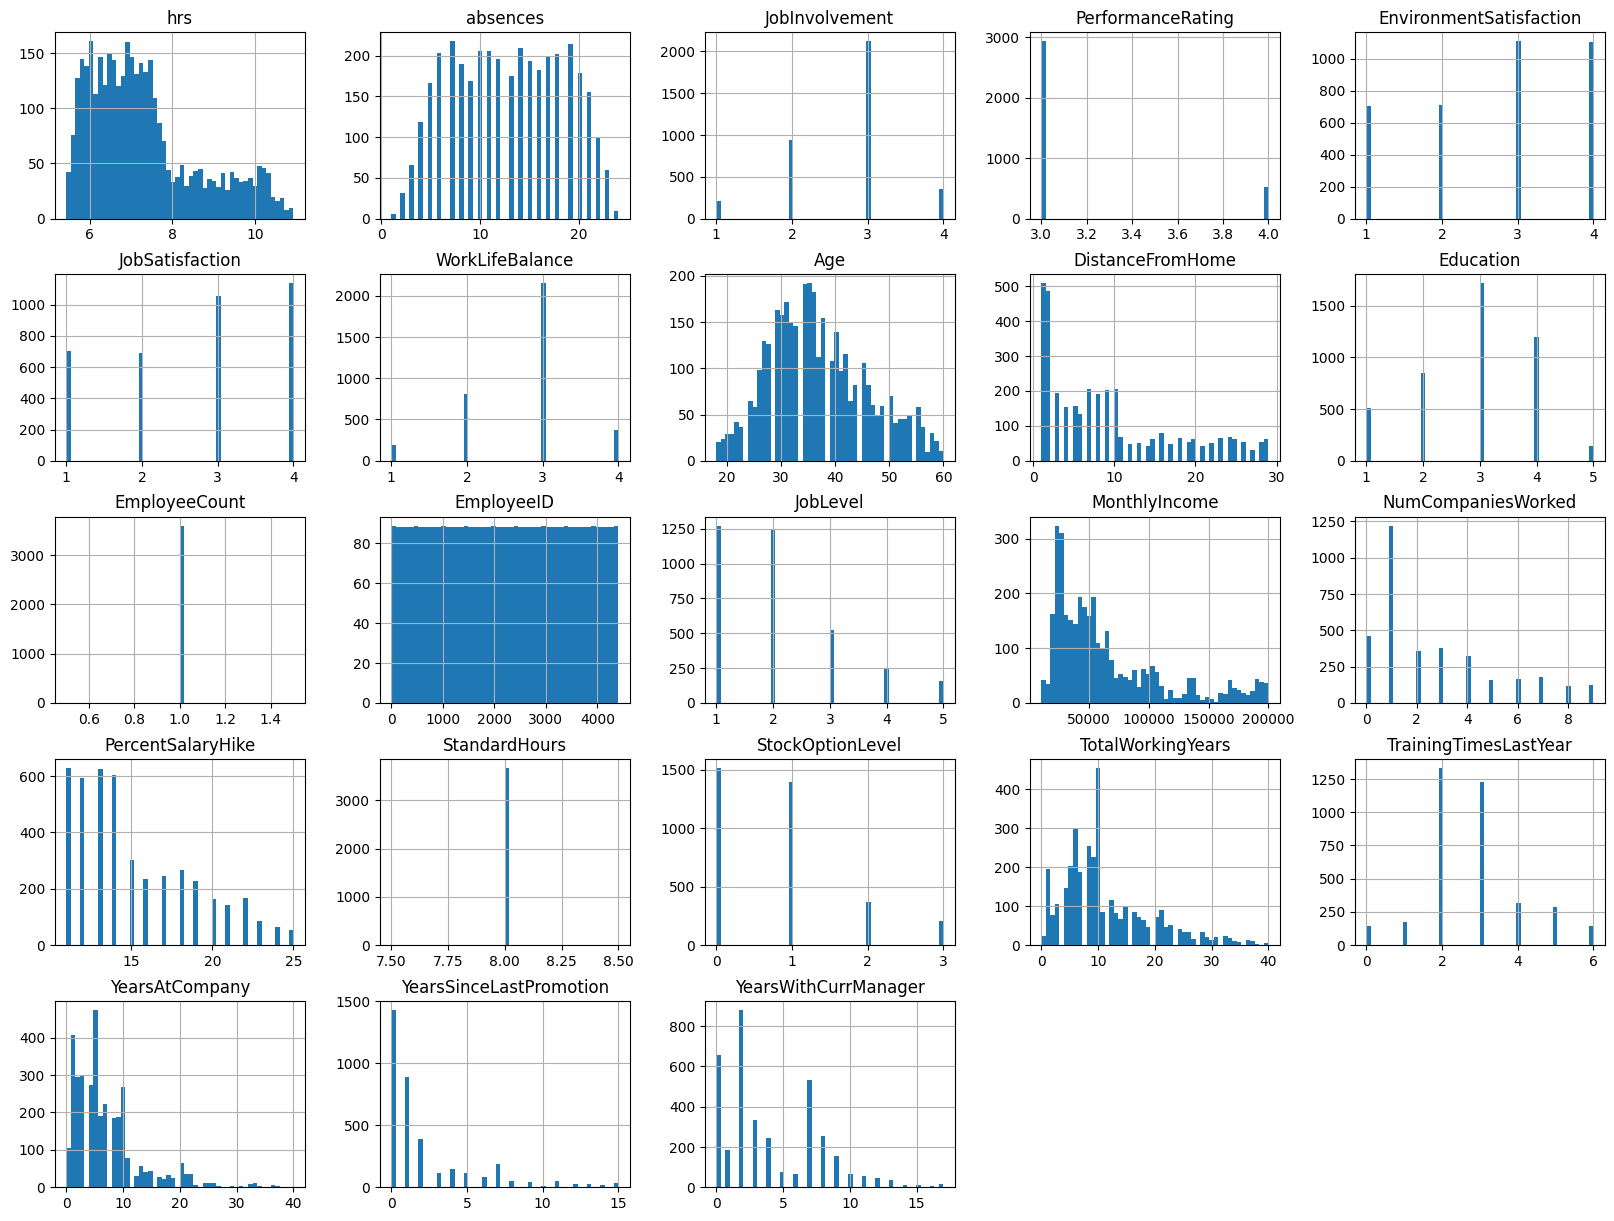

In [221]:
"""HISTOGRAMAS DE NUESTRAS VARIABLES"""
X_data_set.hist(bins=50, figsize=(20,15))
plt.show()



In [222]:
import pandas as pd

# Crear un diccionario vacío para almacenar los resultados
resultados_atipicos = {}

# Recorrer todas las variables numéricas del dataframe
for variable in variables_numericas:
    q1 = X_data_set[variable].quantile(0.25)
    q3 = X_data_set[variable].quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    outliers = X_data_set[(X_data_set[variable] < lim_inf) | (X_data_set[variable] > lim_sup)][variable]
    num_outliers = len(outliers)
    resultados_atipicos[variable] = {"Num_outliers": num_outliers}

# Crear un dataframe final que contenga todos los resultados
df_resultados_at = pd.DataFrame(resultados_atipicos).T
df_resultados_at.index.name = 'Variable'

display(df_resultados_at)


,Num_outliers
Variable,
hrs,107
absences,0
JobInvolvement,0
PerformanceRating,519
EnvironmentSatisfaction,0
JobSatisfaction,0
WorkLifeBalance,0
Age,0
DistanceFromHome,0


Análisis para variables categóricas

In [223]:
import pandas as pd

# Crear un diccionario vacío para almacenar los resultados
resultados = {}

# Recorrer todas las variables categóricas del dataframe
for variable in variables_categoricas:
    # Calcular la frecuencia para cada valor de la variable
    frecuencias = df[variable].value_counts()
    # Crear un nuevo dataframe con la frecuencia para cada valor de la variable
    df_frecuencias = pd.DataFrame({'Valor': frecuencias.index, 'Frecuencia': frecuencias.values})
    # Agregar el dataframe de frecuencias al diccionario de resultados
    resultados[variable] = df_frecuencias

# Crear un dataframe final que contenga todos los resultados
df_resultados = pd.DataFrame(columns=['Variable', 'Valor', 'Frecuencia'])
for variable, df_frecuencias in resultados.items():
    df_frecuencias['Variable'] = variable
    df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
df_resultados = df_resultados[['Variable', 'Valor', 'Frecuencia']]

display(df_resultados)

<ipython-input-223-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-223-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-223-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-223-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-223-56a0f

,Variable,Valor,Frecuencia
0,BusinessTravel,Travel_Rarely,3129
1,BusinessTravel,Travel_Frequently,831
2,BusinessTravel,Non-Travel,450
3,Department,Research & Development,2424
4,Department,Sales,1119
5,Department,Human Resources,159
6,Gender,Male,2101
7,Gender,Female,1401
8,EducationField,Life Sciences,1444
9,EducationField,Medical,1066


In [224]:
import pandas as pd

resultados_moda = {}
for variable in variables_categoricas:

    moda = df[variable].mode().values[0]
    df_moda = pd.DataFrame({'Moda': moda}, index=[variable])

    # Calcular el porcentaje de respuestas de la moda respecto al total de respuestas no nulas
    total_no_nulos = df[variable].notnull().sum()
    porcentaje = df[variable].value_counts(normalize=True).loc[moda] * 100

    # Agregar una nueva columna al DataFrame `df_moda` con el porcentaje de respuestas de la moda
    df_moda['Porcentaje'] = f'{porcentaje:.2f}% de {total_no_nulos} respuestas'

    resultados_moda[variable] = df_moda

df_modas = pd.concat(resultados_moda.values())

# Establecer la columna 'Variable' como el índice del DataFrame
df_modas = df_modas.reset_index().set_index('index')
df_modas.index.name = 'Variable'

# Imprimir el DataFrame `df_modas` como una tabla
print('\nModas y porcentajes de respuestas de variables categóricas:\n')
display(df_modas)



Modas y porcentajes de respuestas de variables categóricas:



,Moda,Porcentaje
Variable,,
BusinessTravel,Travel_Rarely,70.95% de 4410 respuestas
Department,Research & Development,65.48% de 3702 respuestas
Gender,Male,59.99% de 3502 respuestas
EducationField,Life Sciences,41.93% de 3444 respuestas
Over18,Y,100.00% de 3545 respuestas
MaritalStatus,Married,45.67% de 3639 respuestas
JobRole,Sales Executive,22.28% de 3618 respuestas


In [225]:
# Gráfico de barras de las variables categóricas
''' No se por qué da fallo y a ti no te daba, creo que X[col] debería ser X_data_set[col], puede ser?
le = LabelEncoder()
for col in variables_categoricas:
    X_data_set[col] = le.fit_transform(X[col])
X_data_set[variables_categoricas].hist(figsize=(20,15))
plt.show()
'''


' No se por qué da fallo y a ti no te daba, creo que X[col] debería ser X_data_set[col], puede ser?\nle = LabelEncoder()\nfor col in variables_categoricas:\n    X_data_set[col] = le.fit_transform(X[col])\nX_data_set[variables_categoricas].hist(figsize=(20,15))\nplt.show()\n'

In [226]:
# Matriz de correlación
corr_matrix = X_data_set.corr()
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)


<ipython-input-226-6b863cc2da00>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_data_set.corr()
<ipython-input-226-6b863cc2da00>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)
/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
hrs,1.00,-0.37,-0.04,0.06,0.06,0.02,-0.01,0.00,0.01,0.00,nan,-0.00,0.01,-0.01,-0.01,0.02,nan,-0.01,-0.01,-0.00,-0.02,-0.01,-0.02
absences,-0.37,1.00,0.03,0.01,-0.02,0.01,-0.00,0.02,-0.00,0.02,nan,-0.01,0.03,-0.01,0.02,0.01,nan,-0.02,-0.00,-0.01,-0.01,-0.01,-0.02
JobInvolvement,-0.04,0.03,1.00,0.00,0.02,0.01,0.00,0.00,-0.00,-0.03,nan,0.01,-0.00,0.04,0.04,0.00,nan,0.02,0.02,0.00,0.02,0.04,-0.00
PerformanceRating,0.06,0.01,0.00,1.00,0.01,0.05,-0.02,-0.02,0.03,-0.03,nan,0.00,-0.02,0.02,0.03,0.77,nan,-0.02,-0.00,0.00,-0.00,-0.01,-0.03
EnvironmentSatisfaction,0.06,-0.02,0.02,0.01,1.00,-0.01,0.02,0.01,0.01,-0.05,nan,0.01,-0.03,-0.00,0.03,-0.01,nan,-0.01,0.01,0.02,0.00,0.02,0.00
JobSatisfaction,0.02,0.01,0.01,0.05,-0.01,1.00,-0.05,-0.02,-0.01,-0.01,nan,-0.02,-0.01,0.01,-0.04,0.05,nan,0.03,-0.04,-0.04,0.00,-0.03,-0.03
WorkLifeBalance,-0.01,-0.00,0.00,-0.02,0.02,-0.05,1.00,-0.02,0.01,-0.01,nan,-0.01,-0.00,0.01,-0.00,-0.04,nan,-0.02,-0.01,-0.03,0.01,0.01,-0.00
Age,0.00,0.02,0.00,-0.02,0.01,-0.02,-0.02,1.00,0.03,-0.03,nan,0.01,0.02,-0.04,0.31,-0.03,nan,-0.03,0.69,-0.01,0.30,0.22,0.20
DistanceFromHome,0.01,-0.00,-0.00,0.03,0.01,-0.01,0.01,0.03,1.00,-0.01,nan,0.01,-0.05,-0.02,-0.02,0.03,nan,0.01,0.03,0.00,0.05,0.02,0.04
Education,0.00,0.02,-0.03,-0.03,-0.05,-0.01,-0.01,-0.03,-0.01,1.00,nan,-0.01,0.05,-0.00,-0.02,-0.04,nan,-0.00,-0.01,0.01,0.02,0.02,0.01


TUTORIAL 1


In [227]:
# Seleccionados train/test en modo stratify, ya que el dataset se encuentra desbalanceado
X_train, X_test, y_train, y_test = train_test_split(X_data_set, y_data_set, stratify=y_data_set, test_size=0.25, random_state=35)

X_data_set.describe()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3671.000000,3657.000000,3618.000000,3457.000000,3630.000000,3589.000000,3514.000000,3660.000000,3502.000000,4410.000000,...,3510.000000,3478.000000,4410.000000,3676.0,3484.00000,3457.000000,3628.000000,3478.000000,3618.000000,3633.000000
mean,7.306235,12.796828,2.723881,3.150130,2.721763,2.731959,2.768924,36.813115,9.223872,2.912925,...,64983.484330,2.708741,15.209524,8.0,0.78760,11.245878,2.779768,6.958309,2.166667,4.096339
std,1.323201,5.534802,0.713462,0.357251,1.094209,1.105140,0.702638,9.092705,8.100597,1.023933,...,46925.724354,2.504179,3.659108,0.0,0.85444,7.819969,1.278983,6.091550,3.188680,3.567022
min,5.424757,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,...,10090.000000,0.000000,11.000000,8.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.278405,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,...,29110.000000,1.000000,12.000000,8.0,0.00000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.006826,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,...,49360.000000,2.000000,14.000000,8.0,1.00000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.886585,18.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,...,83950.000000,4.000000,18.000000,8.0,1.00000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,...,199990.000000,9.000000,25.000000,8.0,3.00000,40.000000,6.000000,40.000000,15.000000,17.000000


Tratamiento de valores nulos

In [228]:
X_train.isnull().any()
#Los atributos en las que pone False son aquellas en las que no hay ninguna entrada null

hrs                         True
absences                    True
JobInvolvement              True
PerformanceRating           True
EnvironmentSatisfaction     True
JobSatisfaction             True
WorkLifeBalance             True
Age                         True
BusinessTravel             False
Department                  True
DistanceFromHome            True
Education                  False
EducationField              True
EmployeeCount               True
EmployeeID                 False
Gender                      True
JobLevel                    True
JobRole                     True
MaritalStatus               True
MonthlyIncome               True
NumCompaniesWorked          True
Over18                      True
PercentSalaryHike          False
StandardHours               True
StockOptionLevel            True
TotalWorkingYears           True
TrainingTimesLastYear       True
YearsAtCompany              True
YearsSinceLastPromotion     True
YearsWithCurrManager        True
dtype: boo

In [229]:
X_train.isnull().sum()
#Se indica la cantidad de entradas Null que tiene cada atributo

hrs                        546
absences                   587
JobInvolvement             598
PerformanceRating          705
EnvironmentSatisfaction    591
JobSatisfaction            610
WorkLifeBalance            666
Age                        571
BusinessTravel               0
Department                 534
DistanceFromHome           703
Education                    0
EducationField             735
EmployeeCount              601
EmployeeID                   0
Gender                     681
JobLevel                   709
JobRole                    571
MaritalStatus              566
MonthlyIncome              661
NumCompaniesWorked         710
Over18                     654
PercentSalaryHike            0
StandardHours              554
StockOptionLevel           695
TotalWorkingYears          732
TrainingTimesLastYear      570
YearsAtCompany             679
YearsSinceLastPromotion    603
YearsWithCurrManager       590
dtype: int64

Dibujamos los valores que son nulos

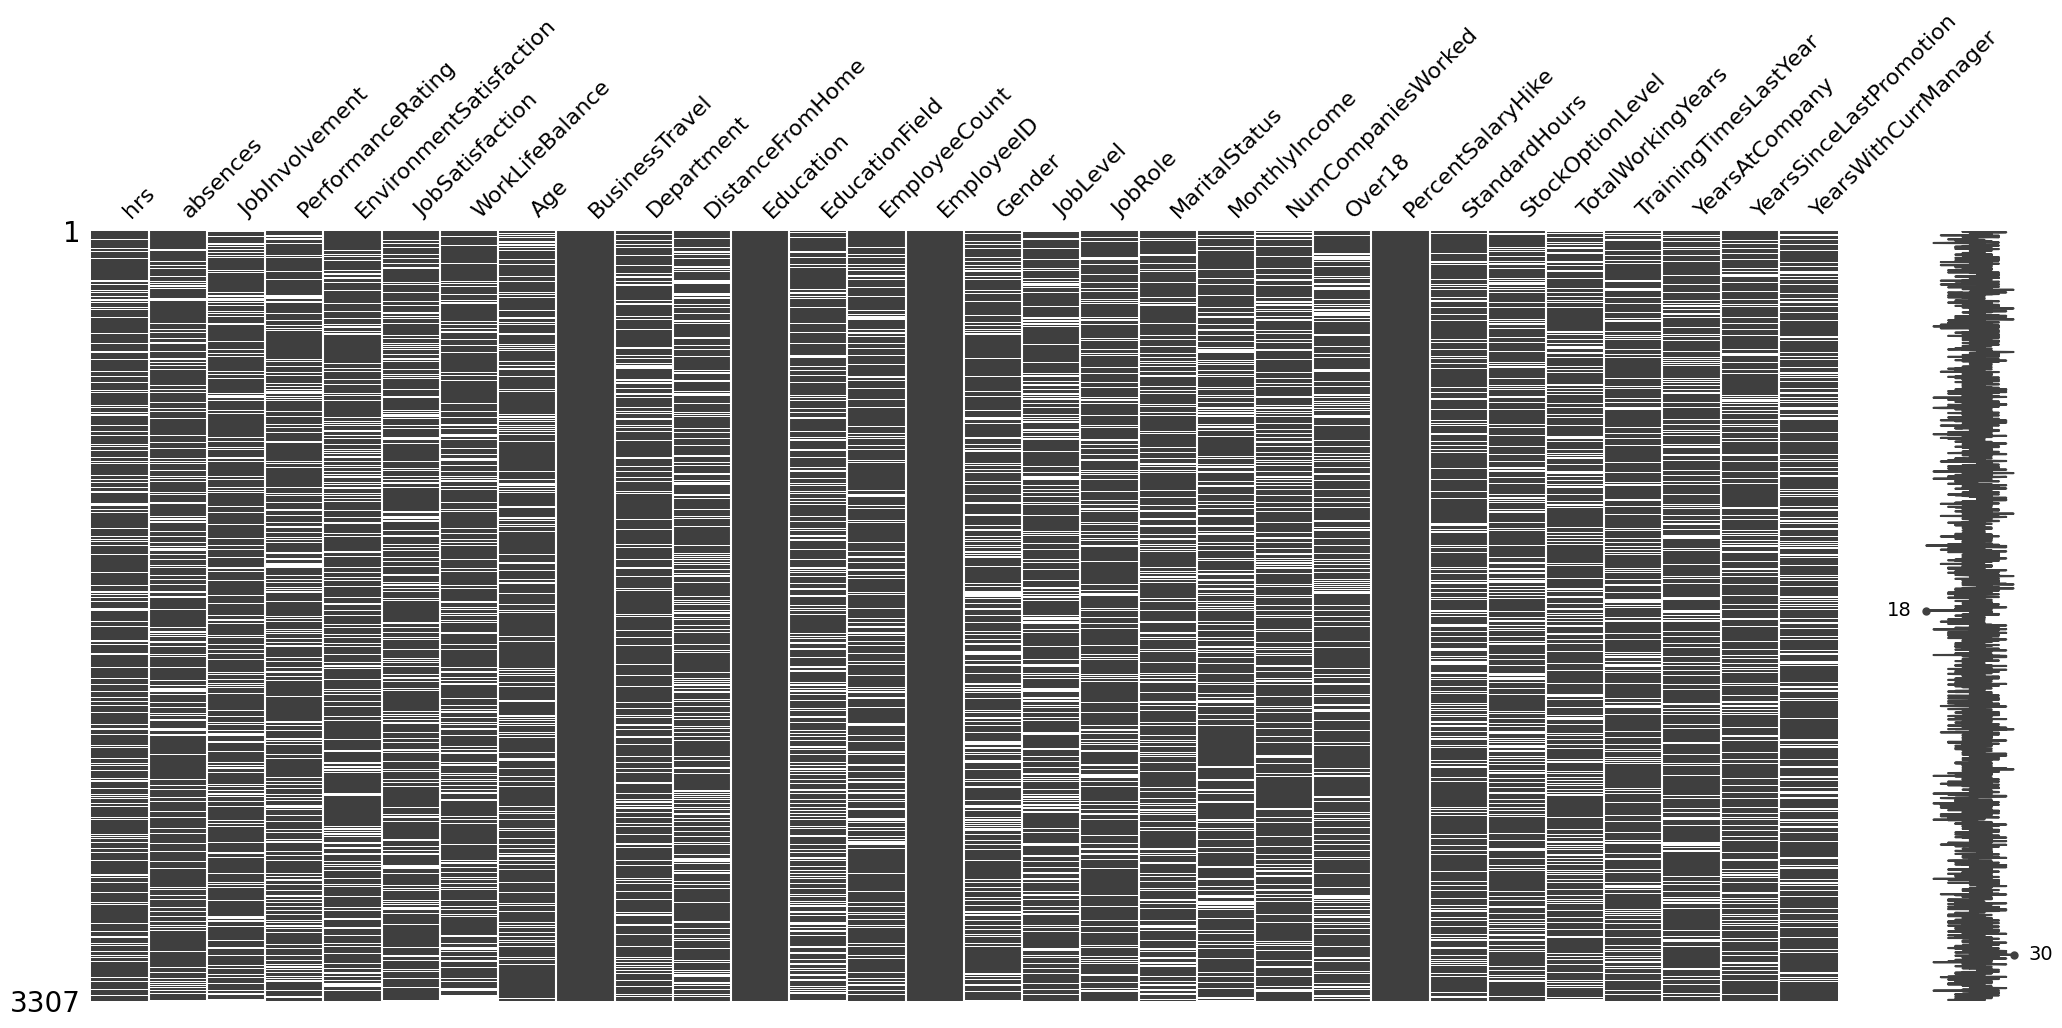

In [230]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(X_train)
plt.show()

#Las entradas son líneas negras, y los huecos blancos

In [231]:
X_train.isnull().sum() / len(X_train) * 100
#Porcentaje de las entradas que son Null

hrs                        16.510432
absences                   17.750227
JobInvolvement             18.082855
PerformanceRating          21.318415
EnvironmentSatisfaction    17.871182
JobSatisfaction            18.445721
WorkLifeBalance            20.139099
Age                        17.266405
BusinessTravel              0.000000
Department                 16.147566
DistanceFromHome           21.257938
Education                   0.000000
EducationField             22.225582
EmployeeCount              18.173571
EmployeeID                  0.000000
Gender                     20.592682
JobLevel                   21.439371
JobRole                    17.266405
MaritalStatus              17.115210
MonthlyIncome              19.987904
NumCompaniesWorked         21.469610
Over18                     19.776232
PercentSalaryHike           0.000000
StandardHours              16.752344
StockOptionLevel           21.016027
TotalWorkingYears          22.134865
TrainingTimesLastYear      17.236166
Y

Parece que no hay ninguna variable con un % de nulos suficientemente grande como para no tener sentido imputar esos valores. por lo que no eliminamos ninguna


Vamos a calcular las correlaciones de los valores numéricos

In [232]:
#Ya lo tenemos arriba, aunque solo tiene sentido hacerlo con los numericos, o al menos es lo que hace el

## Codificamos la salida
Aunque la variable de salida es 0 y 1, pasamos a codificarla con `LabelEncoder` ya que para algunas funciones como el cálculo de las curvas ROC necesitamos esta codificación. 

In [233]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_data_set)

y_test = le.transform(y_test)
y_train = le.transform (y_train)

## Analizar tipos de variables
Vamos a analizar las variables categóricas que tenemos en el dataset

In [234]:
X_train.dtypes

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
BusinessTravel              object
Department                  object
DistanceFromHome           float64
Education                    int64
EducationField              object
EmployeeCount              float64
EmployeeID                   int64
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours              float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear      float64
YearsAtCompany             float64
YearsSinceLastPromot

In [235]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns
#Imprimimos las variables categoricas
cat_cols

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object')

Para las variables categóticas vamos a crear un pipeline donde:
1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificaremos con la técnicas One_Hot_Encoder.
3. Aplicaremos sobre ellos un PCA, para extraer características más discriminantes

In [236]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

In [237]:
# Si queremos acceder al primer paso del pipeline. De la misma forma podríamos acceder a los distintos pasos del pipeline
cat_transformer[0]

SimpleImputer(strategy='most_frequent')

Ahora nos metemos con las variables numéricas. En este caso vamos a realizar el siguiente preproceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos un escalado

In [238]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

En el siguiente código vamos a utilizar la función `ColumnTransformer` para indicar cómo vamos a preprocesar a las variables categóricas y numéricas

In [239]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])
       

In [240]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'Perc...
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object'))])

## Creamos el clasificador
Por último, vamos a crear un `Pipeline` para unir el paso del preproceso, con el paso de entrenamiento del modelo. Fijaros que en el entrenamiento del modelo estoy indicando `class_weight='balanced'`, ya que el dataset se encuentra desbalanceado.

In [241]:
from sklearn.model_selection import cross_val_score
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(class_weight='balanced'))])

Si el valor del parámetro es cv asignado a un número entero y la variable de salida es binaria o multiclase, entonces utiliza StratifiedKFold. Directamente utiliza el valor de shuffle=False. En este caso, lleva a cabo un StratifiedKFold con K=5, y obtenemos el valor medio del accuracy.

In [242]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIn...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [243]:
cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.8624120736227724

Ahora vamos a hacer un RandomizedSearchCV en busca de los mejores valores para aquellos hiperparámetros que hemos establecido antes.


In [244]:
from sklearn.model_selection import RandomizedSearchCV

num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 5))}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=100,random_state=35)

In [245]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'Empl...
                                                                     71, 72, 73,
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...],
                                        'preprocessor__cat__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__cat__pca__n_components': [2,
                                                                                 3,
                                                                                 4],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                                    7,
                                                                                    8,
                                                                                    9,
                                                                                    10,
                                                                                    11,
                                                                                    12,
                                                                                    13,
                                                                                    14]},
                   random_state=35)

In [246]:
random_search.best_score_

0.8881169700764657

In [247]:
random_search.best_params_

{'preprocessor__num__imputer__n_neighbors': 12,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 3,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__n_estimators': 111,
 'classifier__max_depth': 13,
 'classifier__bootstrap': False}

In [248]:
y_pred = random_search.predict(X_test)
y_pred[:5]

array([0, 1, 0, 0, 0])

In [249]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       925
           1       0.85      0.45      0.59       178

    accuracy                           0.90      1103
   macro avg       0.88      0.72      0.77      1103
weighted avg       0.89      0.90      0.88      1103



La precisión balanceada se usa en problemas de clasificación binaria y multiclase para tratar conjuntos de datos desbalanceados. Se define como la media del recall obtenido en cada clase.

In [250]:
from sklearn.metrics import balanced_accuracy_score

print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")


El valor de balanced accuracy: 0.7171515335560279


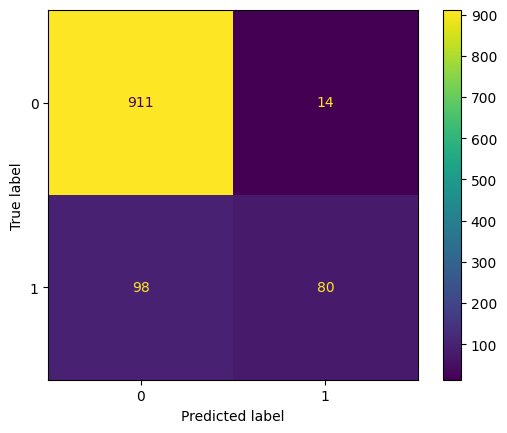

In [251]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=random_search.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot()
plt.show()

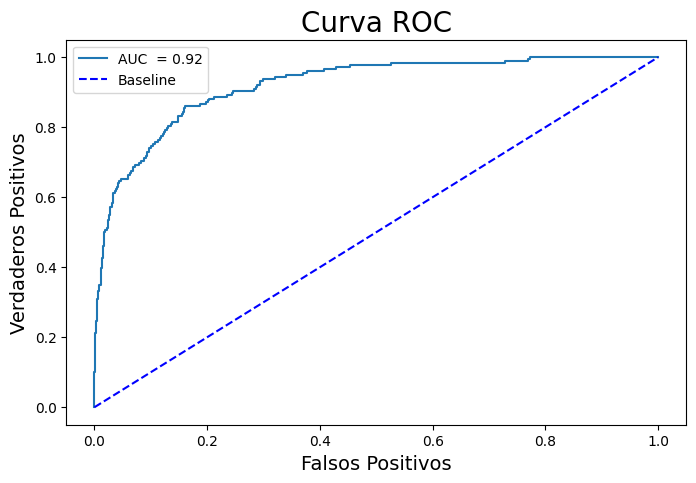

In [252]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = random_search.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

In [253]:
# Modelo final
modelo_final = random_search.best_estimator_
_ = modelo_final.fit (X_data_set,y_data_set)
#El _ hace que no se guarde el modelo entrenado, no sé or qué lo hacemos pero bueno